In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [76]:
# 다른 방법
df_backup = pd.read_csv("https://raw.githubusercontent.com/blueage98/ML/main/time_series/energy_3years.csv",
                 parse_dates=['timestamp'])

df_backup.set_index("timestamp", inplace=True)

print(df_backup.shape)
df_backup[:3]

(26304, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


In [77]:
# 시간단위 데이터 --> 일단위 총합 데이터로 변경.
df_down = df_backup.resample('D').sum()
print(df_down.shape)
df_down[:3]

(1096, 2)


,load,temp
timestamp,,
2012-01-01,71562.0,906.333333
2012-01-02,76841.0,897.666667
2012-01-03,87887.0,418.333333


In [78]:
# load 일-합계 | temp 일-합계 | temp 일-평균
df_down['temp_mean'] = df_backup.temp.resample('D').mean()
df_down[:3]

,load,temp,temp_mean
timestamp,,,
2012-01-01,71562.0,906.333333,37.763889
2012-01-02,76841.0,897.666667,37.402778
2012-01-03,87887.0,418.333333,17.430556


# 단변수 시계열 예측

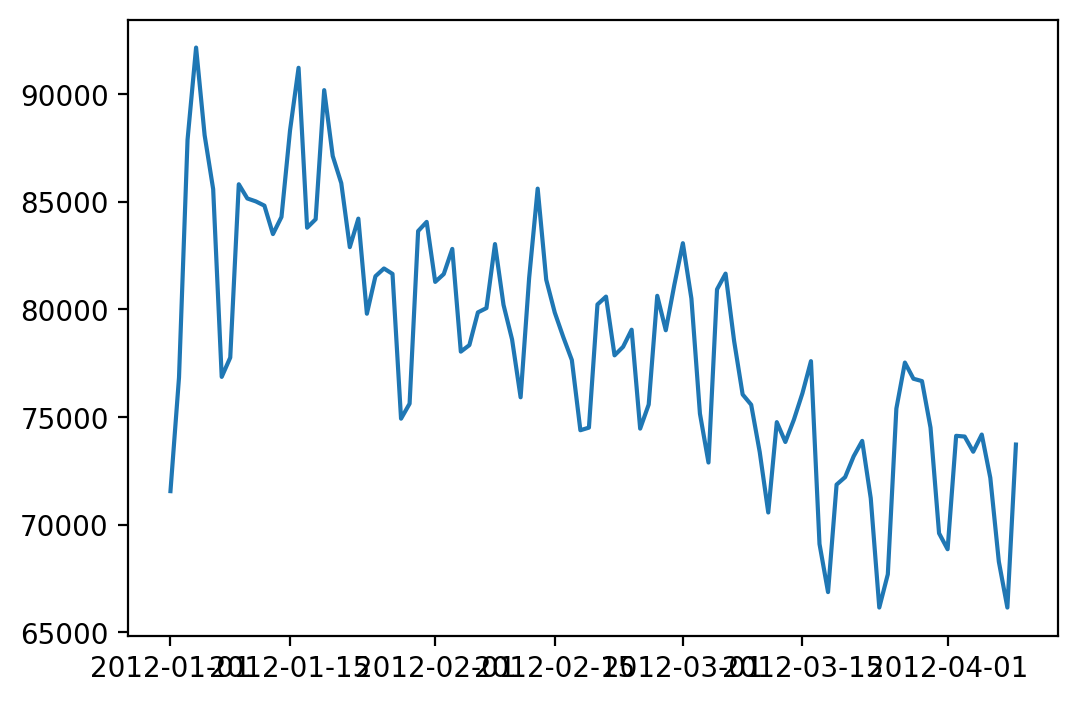

In [79]:
# [load 일-합계] 열의 n개 데이터를 가지고 그 다음 데이터 예측
df = df_down.copy()
y = df.load
plt.plot(y[:100])

## 선형 예측 (LinearRegression)

In [80]:
ratio = 0.75
cut = np.int(len(y)*ratio)
train_data = y[:cut]
test_data = y[cut:]
len(y), len(train_data), len(test_data)

<ipython-input-80-fe3065d53ba6>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut = np.int(len(y)*ratio)


(1096, 822, 274)

In [81]:
def split_seq(data, n_steps):
    x, y = [], []
    for i in range(len(data)):
        if i > len(data) - (n_steps + 1) : break
        x.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(x), np.array(y)

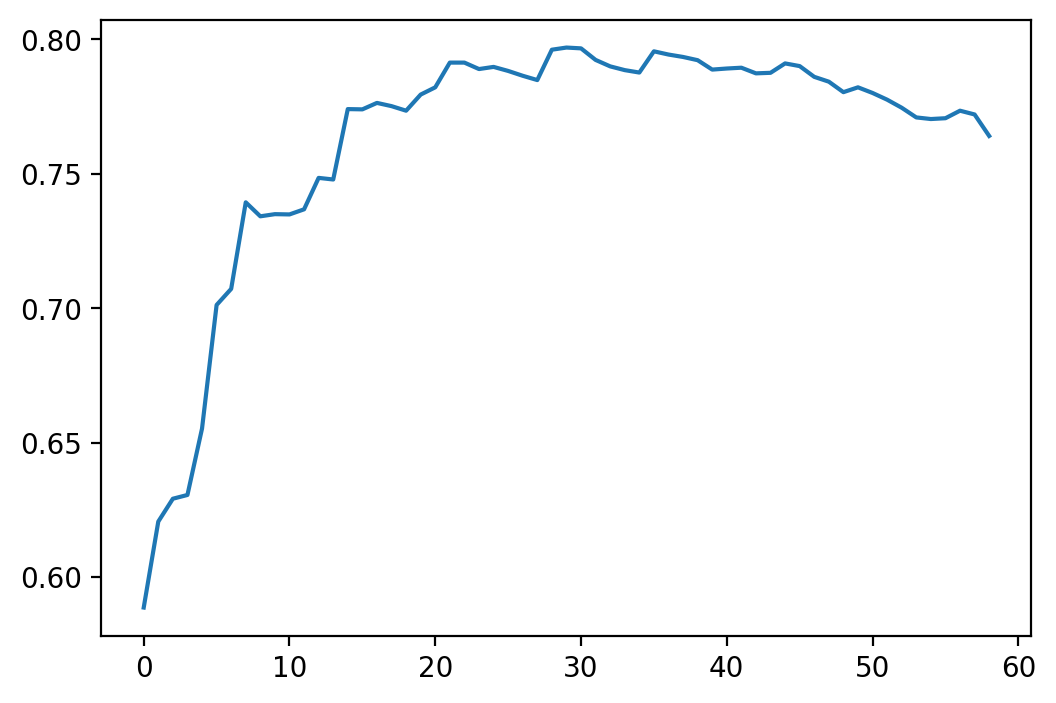

In [82]:
model = LinearRegression()
result = {}
for n_steps in range(1,60,1):
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    y_pred = model.predict(x_test)
    result[n_steps]= r2_score(y_test, y_pred).round(4)
plt.plot(result.values())

In [83]:
result

{1: 0.5886,
 2: 0.6206,
 3: 0.6291,
 4: 0.6305,
 5: 0.6552,
 6: 0.7012,
 7: 0.7072,
 8: 0.7394,
 9: 0.7342,
 10: 0.735,
 11: 0.7349,
 12: 0.7368,
 13: 0.7485,
 14: 0.7479,
 15: 0.7741,
 16: 0.774,
 17: 0.7764,
 18: 0.7752,
 19: 0.7735,
 20: 0.7795,
 21: 0.7822,
 22: 0.7914,
 23: 0.7914,
 24: 0.789,
 25: 0.7898,
 26: 0.7883,
 27: 0.7865,
 28: 0.7849,
 29: 0.7962,
 30: 0.797,
 31: 0.7967,
 32: 0.7924,
 33: 0.79,
 34: 0.7886,
 35: 0.7877,
 36: 0.7956,
 37: 0.7944,
 38: 0.7935,
 39: 0.7923,
 40: 0.7888,
 41: 0.7892,
 42: 0.7895,
 43: 0.7874,
 44: 0.7876,
 45: 0.7911,
 46: 0.7901,
 47: 0.7861,
 48: 0.7843,
 49: 0.7804,
 50: 0.7822,
 51: 0.7801,
 52: 0.7776,
 53: 0.7746,
 54: 0.771,
 55: 0.7704,
 56: 0.7707,
 57: 0.7735,
 58: 0.7721,
 59: 0.7641}

In [84]:
# 과거 30일 데이터를 가지고 내일 예측 시 가장 정확
max_steps = max(result, key=result.get)
print("max_steps=", max_steps)

max_steps= 30


In [85]:
def show_regression_result(y_test, y_pred, N=100):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean().round(4))
    print("max error=", max(error).round(4))
    #  잔차  (residue) 산포도
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.scatter(y_test, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

### 결과

MAE= 2220.2821
max error= 14205.8371
R2= 0.797


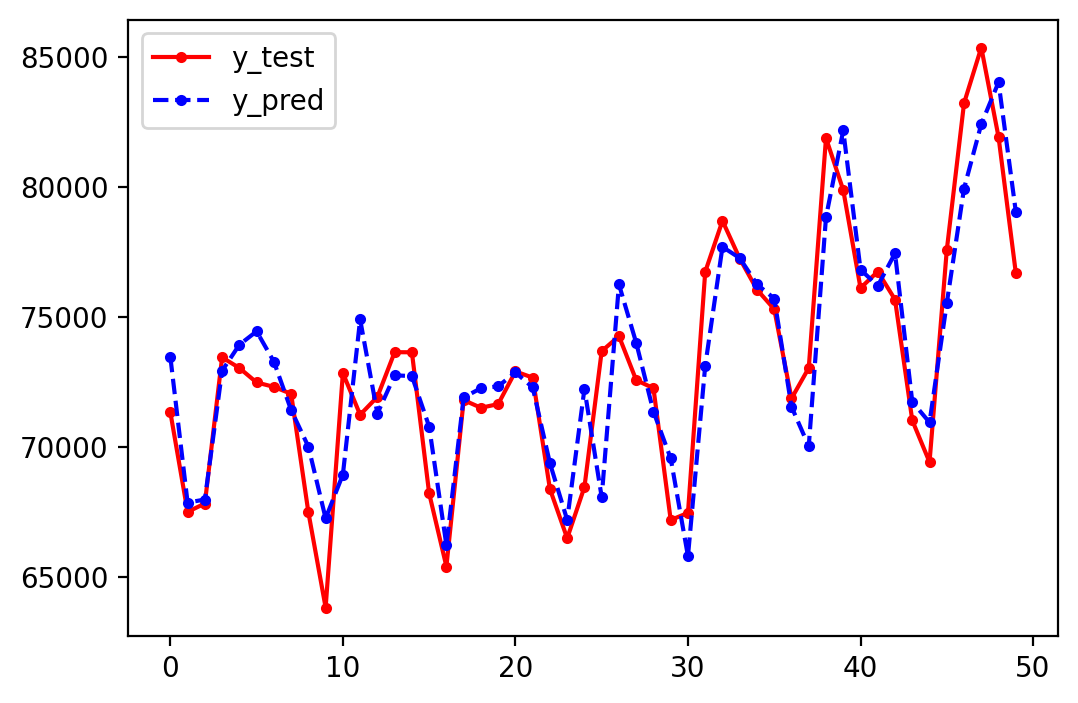

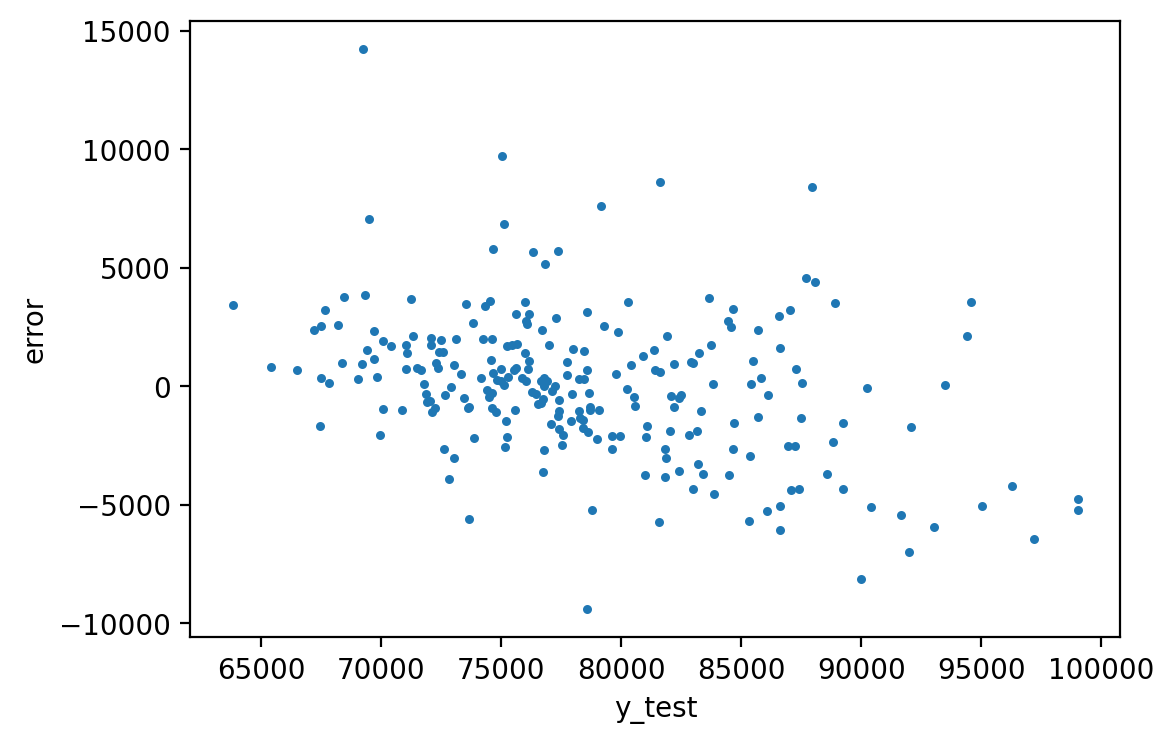

In [86]:
# 과거 30일 데이터로 내일 데이터 예측 (LinearRegression)
x_train, y_train = split_seq(train_data, max_steps)
x_test, y_test = split_seq(test_data, max_steps)
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)

# 예측 결과 플로팅
show_regression_result(y_test, y_pred, 50)

## 결정나무 예측(RandomForest)

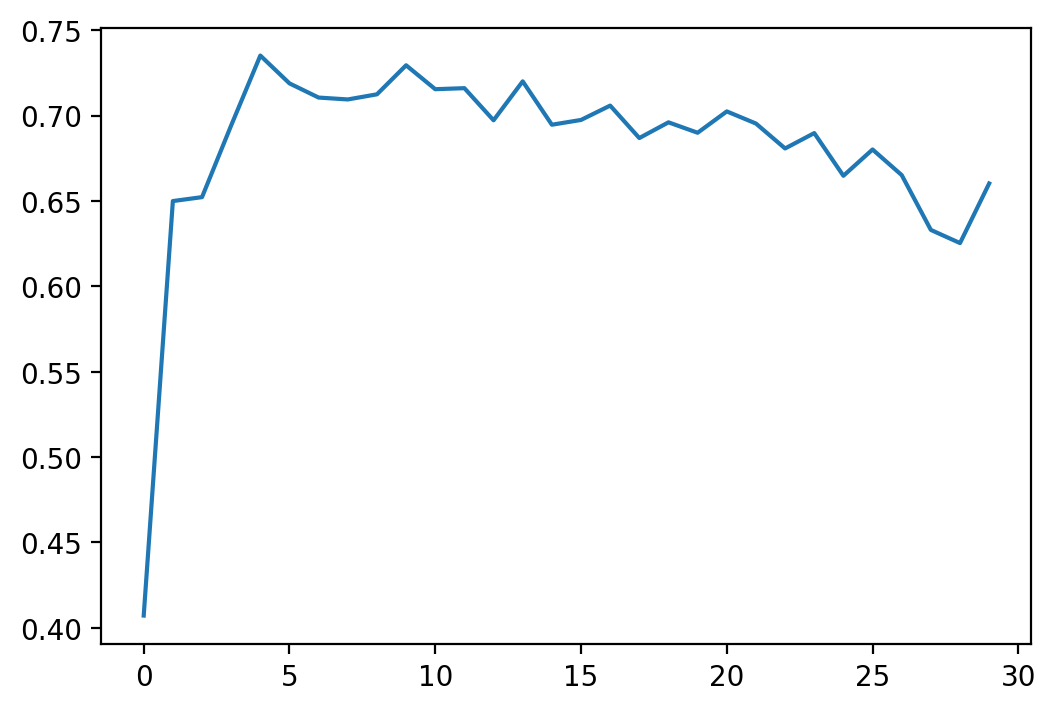

In [87]:
# 랜덤포레스트로 단변수 예측
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=20)

result = {}
for n_steps in range(1,60,2):
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    y_pred = model.predict(x_test)
    result[n_steps]= r2_score(y_test, y_pred).round(4)
plt.plot(result.values())

In [88]:
# 과거 9일 데이터를 가지고 내일 예측 시 가장 정확
max_steps = max(result, key=result.get)
print("max_steps=", max_steps)

max_steps= 9


### 결과

MAE= 2443.8884
max error= 14460.8
R2= 0.7346


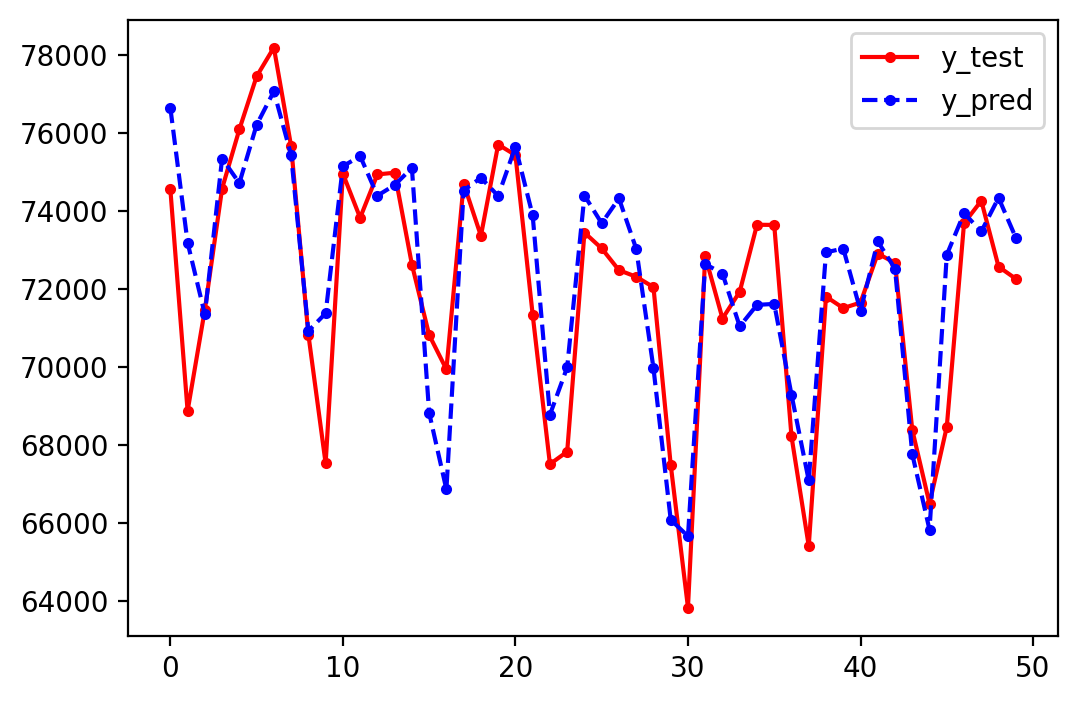

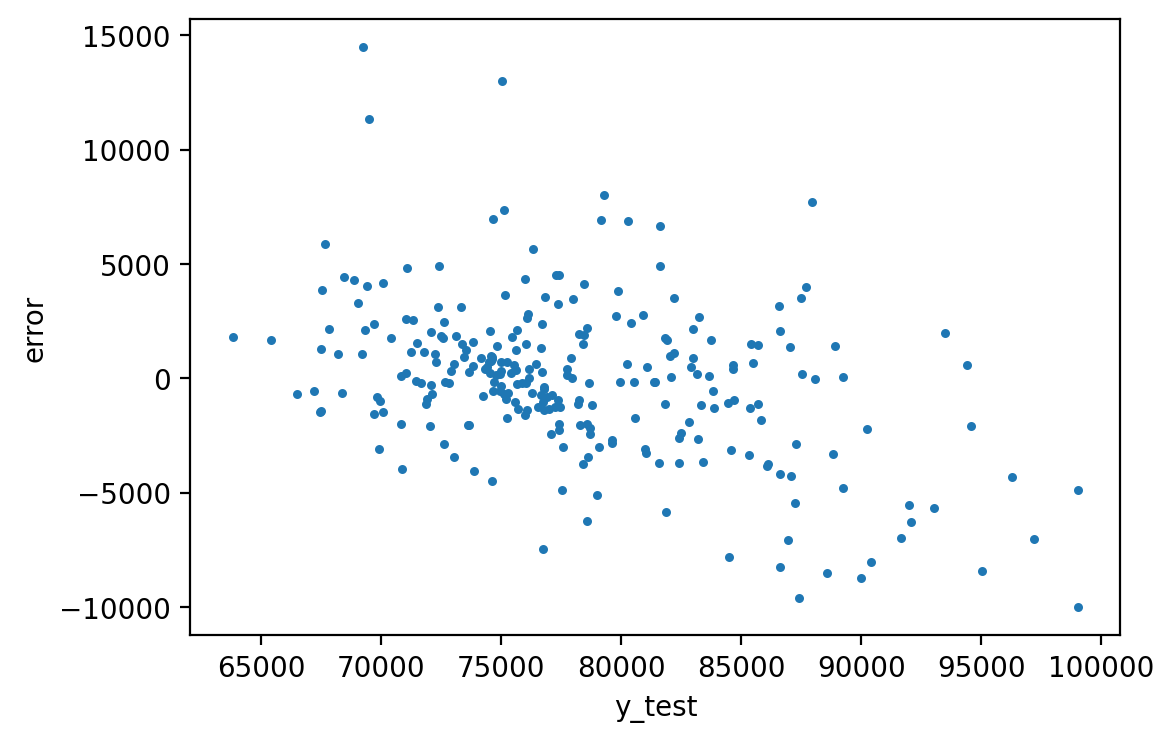

In [89]:
x_train, y_train = split_seq(train_data, max_steps)
x_test, y_test = split_seq(test_data, max_steps)
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)
show_regression_result(y_test, y_pred, 50)

# 특성 추가

## 이동평균 생성
- 데이터프레임을 출력

In [90]:
# load값 : 직전 5일의 평균 데이터 추가 (20이 아니라 1개라도 있으면 연산)
df["5-mean"] = df.load.rolling(5,min_periods=1).mean()
df[:10]

,load,temp,temp_mean,5-mean
timestamp,,,,
2012-01-01,71562.0,906.333333,37.763889,71562.000000
2012-01-02,76841.0,897.666667,37.402778,74201.500000
2012-01-03,87887.0,418.333333,17.430556,78763.333333
2012-01-04,92168.0,314.666667,13.111111,82114.500000
2012-01-05,88096.0,597.000000,24.875000,83310.800000
2012-01-06,85591.0,621.666667,25.902778,86116.600000
2012-01-07,76869.0,759.666667,31.652778,86122.200000
2012-01-08,77767.0,720.000000,30.000000,84098.200000
2012-01-09,85818.0,606.666667,25.277778,82828.200000


In [91]:
# 직전 20일의 평균 데이터 추가 (20이 아니라 1개라도 있으면 연산)
df["20-mean"] = df.load.rolling(20,min_periods=1).mean()
# 직전 20일의 표준편차 데이터 추가 (20이 아니라 1개라도 있으면 연산)
df["10-std"] = df.load.rolling(10, min_periods=1).std().fillna(0)
df[:5]

,load,temp,temp_mean,5-mean,20-mean,10-std
timestamp,,,,,,
2012-01-01,71562.0,906.333333,37.763889,71562.000000,71562.000000,0.000000
2012-01-02,76841.0,897.666667,37.402778,74201.500000,74201.500000,3732.816698
2012-01-03,87887.0,418.333333,17.430556,78763.333333,78763.333333,8330.542019
2012-01-04,92168.0,314.666667,13.111111,82114.500000,82114.500000,9549.165356
2012-01-05,88096.0,597.000000,24.875000,83310.800000,83310.800000,8691.696480


In [92]:
df.columns

Index(['load', 'temp', 'temp_mean', '5-mean', '20-mean', '10-std'], dtype='object')

In [93]:
features = ['load', 'temp_mean', '5-mean', '20-mean', '10-std']
X = df[features]
n_features = len(features)

In [94]:
# 데이터 나누기
ratio = 0.75
cut = np.int(len(X)*ratio)
train_data = X[:cut]
test_data = X[cut:]
len(X), len(train_data), len(test_data)

<ipython-input-94-c2345c81ceb2>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut = np.int(len(X)*ratio)


(1096, 822, 274)

In [95]:
train_data

,load,temp_mean,5-mean,20-mean,10-std
timestamp,,,,,
2012-01-01,71562.0,37.763889,71562.000000,71562.000000,0.000000
2012-01-02,76841.0,37.402778,74201.500000,74201.500000,3732.816698
2012-01-03,87887.0,17.430556,78763.333333,78763.333333,8330.542019
2012-01-04,92168.0,13.111111,82114.500000,82114.500000,9549.165356
2012-01-05,88096.0,24.875000,83310.800000,83310.800000,8691.696480
...,...,...,...,...,...
2014-03-28,80389.0,38.611111,83669.200000,81893.775000,3166.196148
2014-03-29,73567.0,40.611111,81440.400000,81722.150000,3990.450596
2014-03-30,77056.0,35.472222,80013.600000,81404.550000,4128.702922


In [96]:
train_data.shape, test_data.shape # 특성 수가 1이 아니라 5로 늘었다

((822, 5), (274, 5))

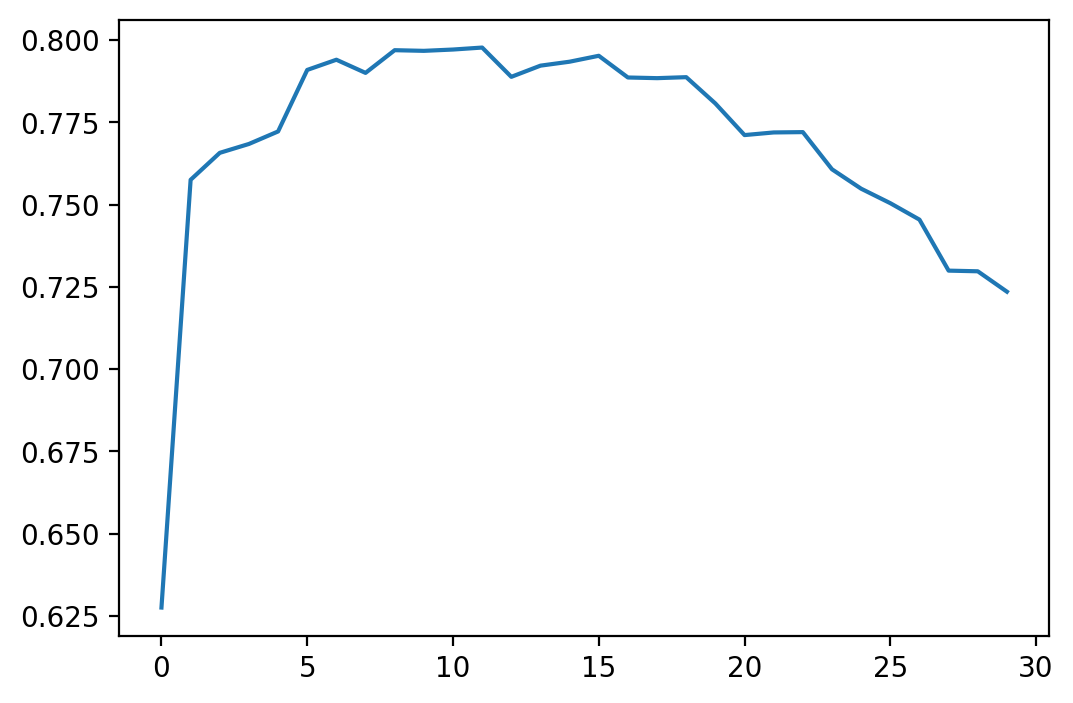

In [97]:
# 직전 n_steps일 간의 [load | temp_mean | 5-mean | 20-mean | 10-std] 데이터를 가지고 내일 load 값 예측
model = LinearRegression()
result = {}
for n_steps in range(1,60,2):
    x_train, y_train = split_seq(train_data.values, n_steps)
    x_train_flat = x_train.reshape(-1, n_steps*n_features)
    x_test, y_test = split_seq(test_data.values, n_steps)
    x_test_flat = x_test.reshape(-1, n_steps*n_features)
    model.fit(x_train_flat, y_train[:,0]) # 주의: 선형모델은 벡터 형의 y값만 구할 수 있다
    y_pred = model.predict(x_test_flat)
    result[n_steps]= r2_score(y_test[:,0], y_pred).round(4)
plt.plot(result.values())

In [98]:
# 과거 23일 데이터를 가지고 내일 예측 시 가장 정확
max_steps = max(result, key=result.get)
print("max_steps=", max_steps)

max_steps= 23


### 결과

MAE= 2196.8313
max error= 13285.7236
R2= 0.7977


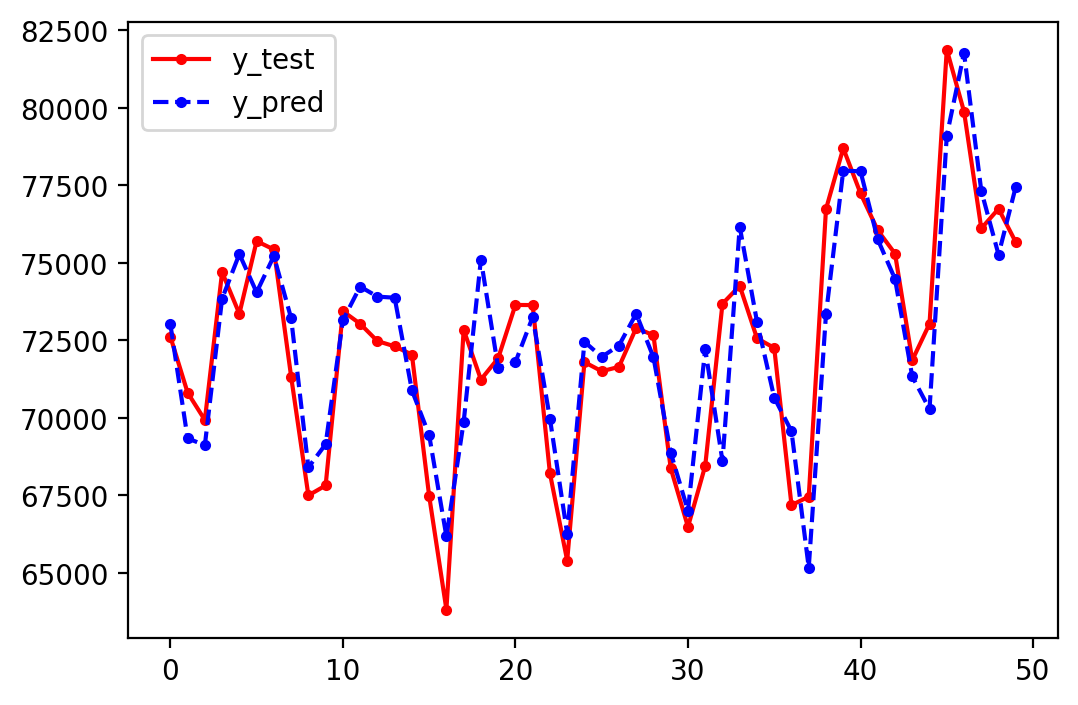

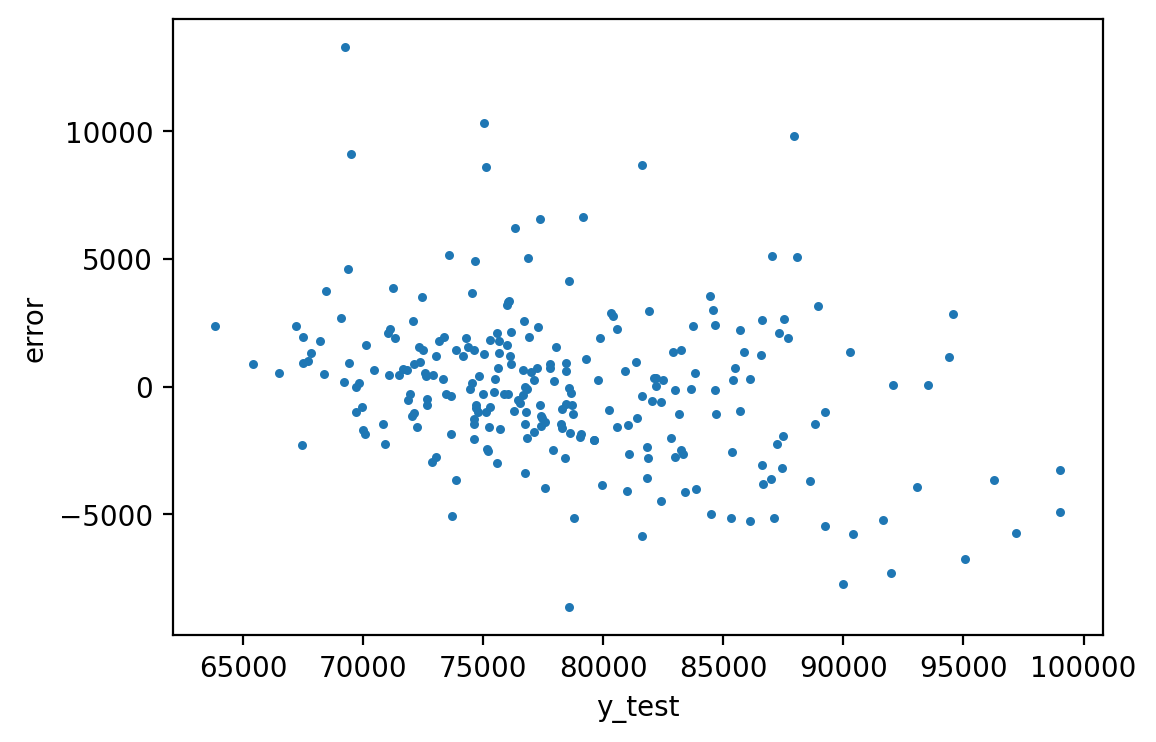

In [99]:
n_steps = max_steps
x_train, y_train = split_seq(train_data.values, n_steps)
x_train_flat = x_train.reshape(-1, n_steps*n_features)

x_test, y_test = split_seq(test_data.values, n_steps)
x_test_flat = x_test.reshape(-1, n_steps*n_features)

model.fit(x_train_flat, y_train[:,0]) 
y_pred = model.predict(x_test_flat)

show_regression_result(y_test[:,0], y_pred, 50)

## 같은 조건에서 Scaling 적용

In [100]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_sc = scaler.fit_transform(x_train_flat)
x_test_sc = scaler.transform(x_test_flat)

MAE= 2196.8482
max error= 13279.5074
R2= 0.7976


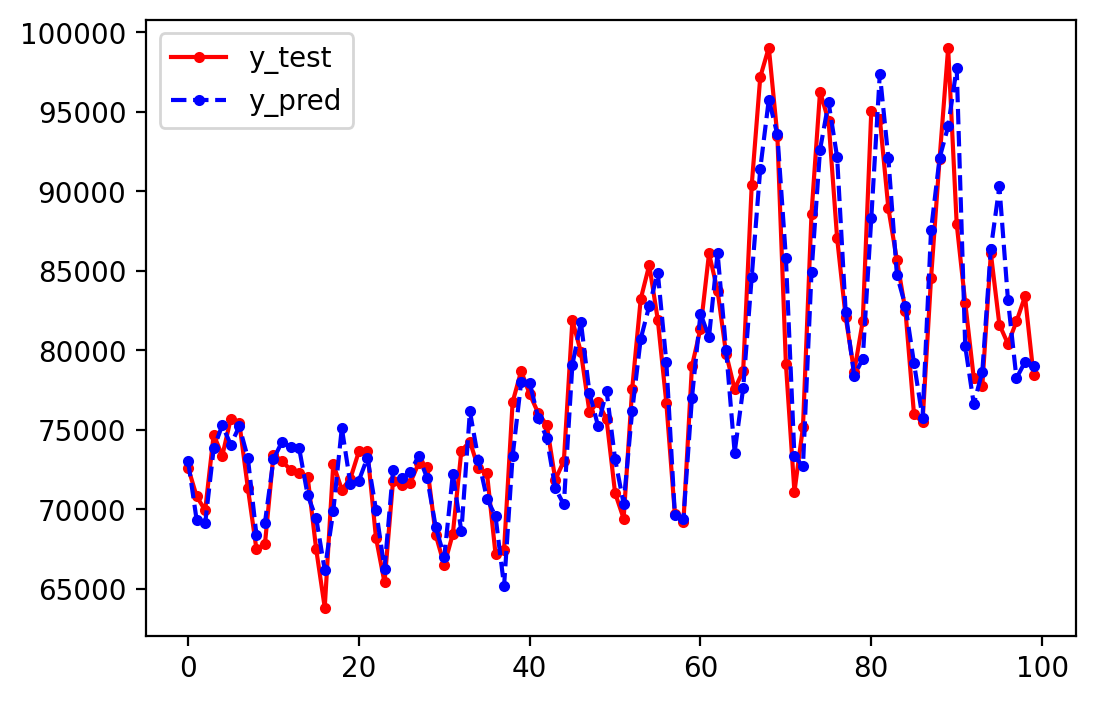

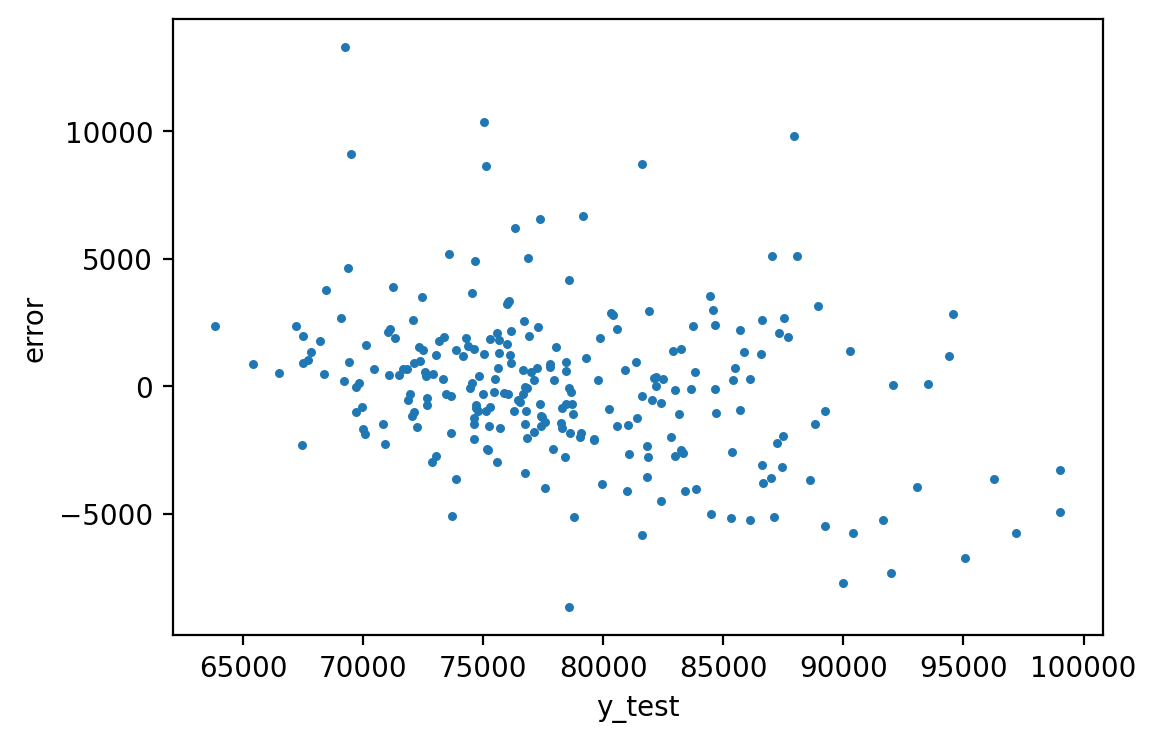

In [101]:
model.fit(x_train_sc, y_train[:,0]) 
y_pred = model.predict(x_test_sc)
show_regression_result(y_test[:,0], y_pred)

# 다차항 추가
- Polynomial

In [102]:
df1 = df_down[['load', 'temp']].copy()

# 데이터 나누기
ratio = 0.75
cut = np.int(len(X)*ratio)
train_data = df1[:cut]
test_data = df1[cut:]
len(df1), len(train_data), len(test_data)

<ipython-input-102-31da60b37d8b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut = np.int(len(X)*ratio)


(1096, 822, 274)

In [103]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
train_poly = poly.fit_transform(train_data)
test_poly = poly.fit_transform(test_data)

features = poly.get_feature_names_out()
n_features = len(features)

print("PolynomialFeature를 2차로 적용하면 아래와 같이 열 추가된다.")
print(features)
print(n_features)
print(train_poly.shape)
print(test_poly.shape)

PolynomialFeature를 2차로 적용하면 아래와 같이 열 추가된다.
['1' 'load' 'temp' 'load^2' 'load temp' 'temp^2']
6
(822, 6)
(274, 6)


In [104]:
train_poly = pd.DataFrame(train_poly)
test_poly = pd.DataFrame(test_poly)

#첫번째 열에 상수 1만 들어있는 상수열이 추가되어 이를 제거함.
train_poly.drop(train_poly.columns[0], axis=1, inplace=True)
test_poly.drop(test_poly.columns[0], axis=1, inplace=True)
n_features = n_features -1

print(train_poly.shape)
print(test_poly.shape)
print(n_features)

train_poly

(822, 5)
(274, 5)
5


,1,2,3,4,5
0,71562.0,906.333333,5.121120e+09,6.485903e+07,821440.111111
1,76841.0,897.666667,5.904539e+09,6.897760e+07,805805.444443
2,87887.0,418.333333,7.724125e+09,3.676606e+07,175002.777780
3,92168.0,314.666667,8.494940e+09,2.900220e+07,99015.111111
4,88096.0,597.000000,7.760905e+09,5.259331e+07,356409.000000
...,...,...,...,...,...
817,80389.0,926.666667,6.462391e+09,7.449381e+07,858711.111110
818,73567.0,974.666667,5.412103e+09,7.170330e+07,949975.111116
819,77056.0,851.333333,5.937627e+09,6.560034e+07,724768.444447
820,82707.0,831.333333,6.840448e+09,6.875709e+07,691115.111114


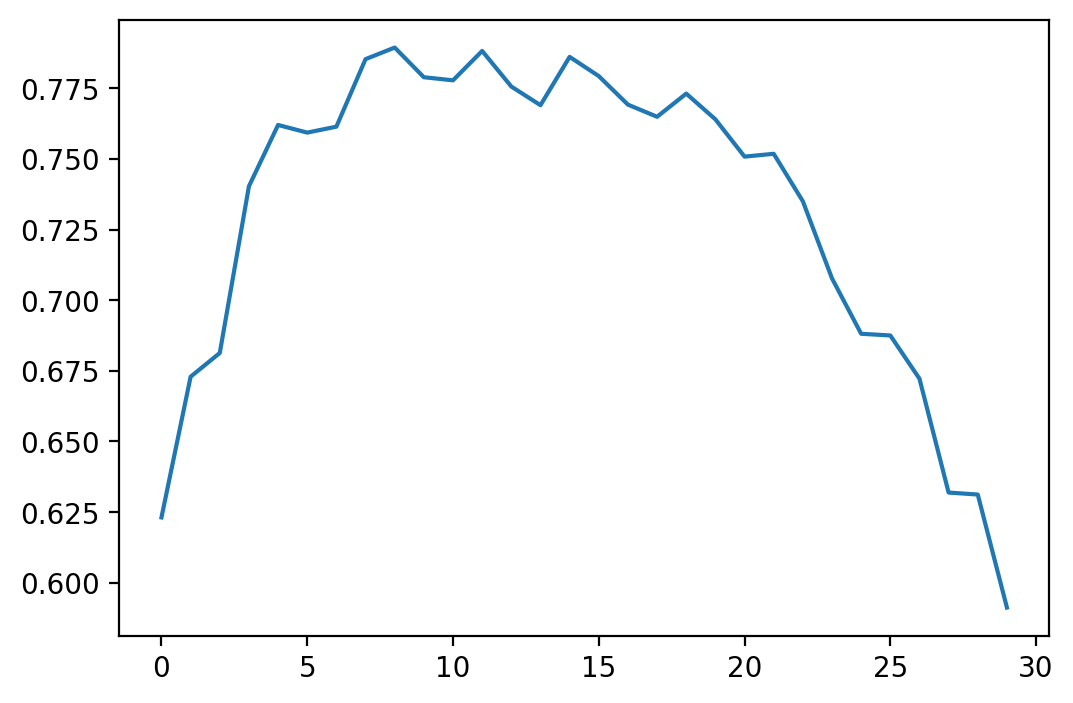

In [105]:
model = LinearRegression()
result = {}
for n_steps in range(1,60,2):
    x_train, y_train = split_seq(train_poly.values, n_steps)
    x_train_flat = x_train.reshape(-1, n_steps*n_features)
    x_test, y_test = split_seq(test_poly.values, n_steps)
    x_test_flat = x_test.reshape(-1, n_steps*n_features)
    model.fit(x_train_flat, y_train[:,0]) # 주의: 선형모델은 벡터 형의 y값만 구할 수 있다
    y_pred = model.predict(x_test_flat)
    result[n_steps]= r2_score(y_test[:,0], y_pred).round(4)
plt.plot(result.values())

In [106]:
# 과거 17일 데이터를 가지고 내일 예측 시 가장 정확
max_steps = max(result, key=result.get)
print("max_steps=", max_steps)

max_steps= 17


### 결과

MAE= 2177.3195
max error= 14214.0965
R2= 0.7894


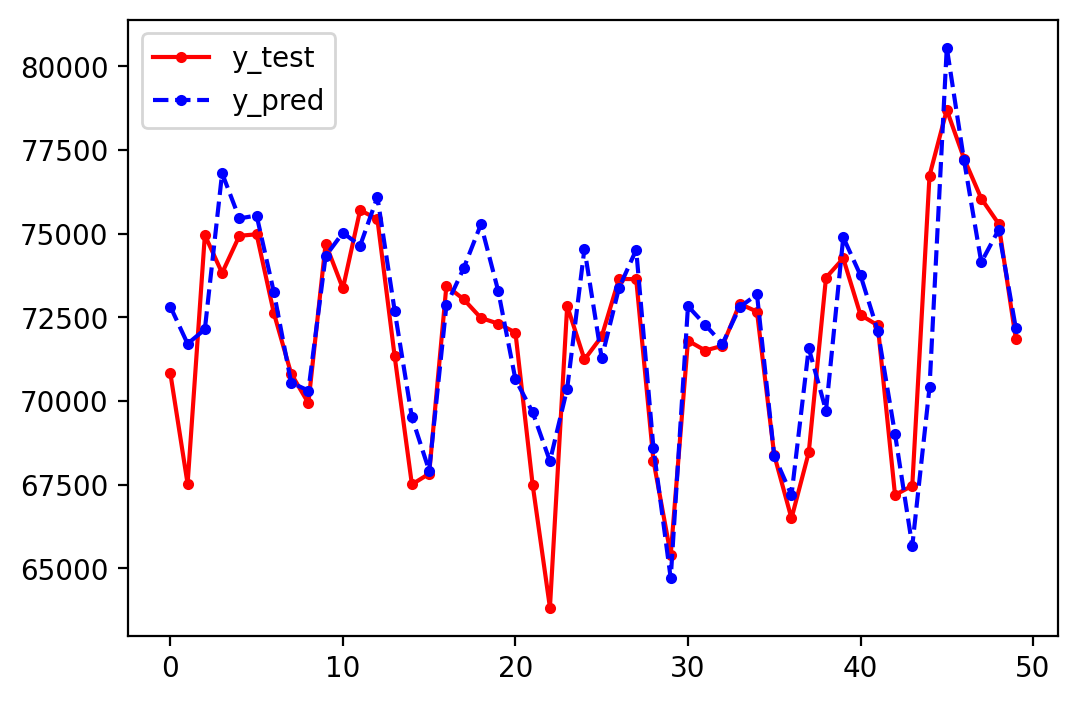

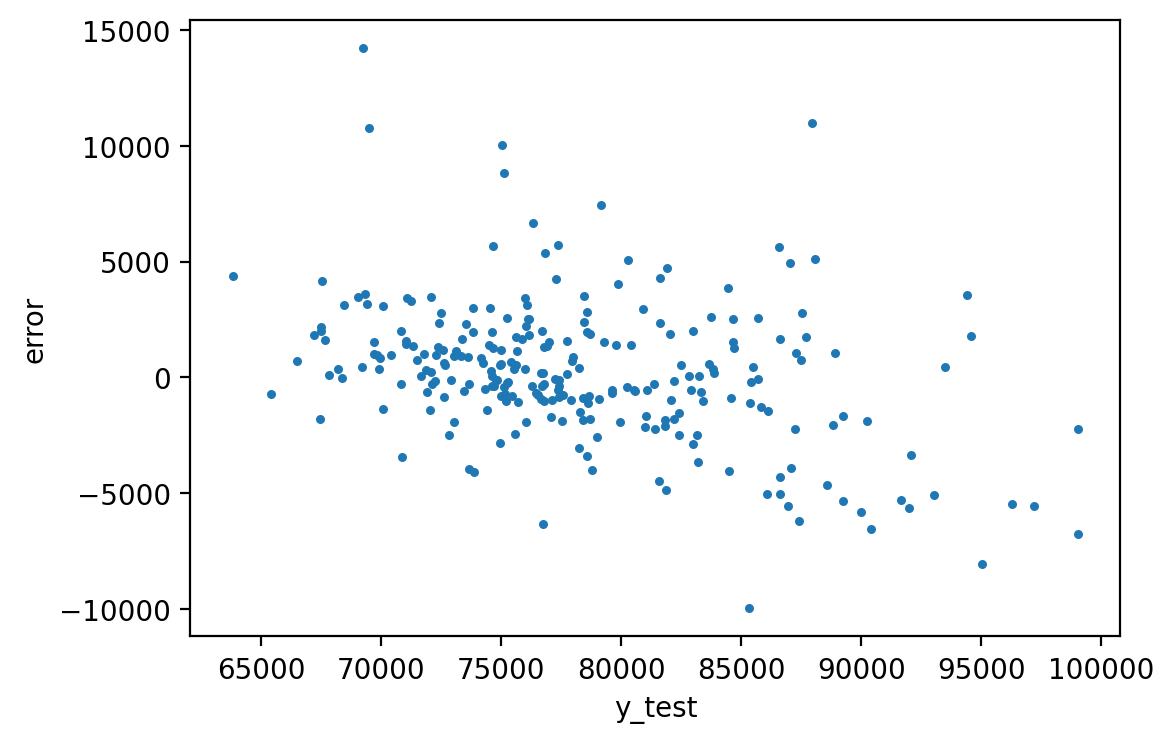

In [107]:
n_steps = max_steps
x_train, y_train = split_seq(train_poly.values, n_steps)
x_train_flat = x_train.reshape(-1, n_steps*n_features)

x_test, y_test = split_seq(test_poly.values, n_steps)
x_test_flat = x_test.reshape(-1, n_steps*n_features)

model.fit(x_train_flat, y_train[:,0]) 
y_pred = model.predict(x_test_flat)

show_regression_result(y_test[:,0], y_pred, 50)